In [1]:
!pip install openai

In [5]:
import openai
import pandas as pd
from tqdm import tqdm
from collections import Counter
import time
import json

In [6]:
# OpenAI API Key 
openai.api_key = "my key" 
client = OpenAI(api_key = openai.api_key)

In [7]:
# Load Excel
file_path = "/Users/yintianyi/Desktop/Desktop - 殷天逸的MacBook Air (2)/投出去的简历.xlsx"
sheet_name = "24年8月-9月"  
df = pd.read_excel(file_path, sheet_name=sheet_name)
descriptions = df['JD'].dropna().astype(str).tolist()

In [8]:
# Define Prompt
def build_prompt(text):
    return f"""
You are a career assistant helping a job seeker identify the most valuable technical skills.

From the job description below, extract relevant technical skills in these categories:
- Programming languages
- Data/analytics tools
- Business intelligence platforms
- Machine learning frameworks
- Cloud/data infrastructure tools

❗️Return ONLY a JSON object in this format:
{{
    "skills": ["skill1", "skill2", "skill3"]
}}

Exclude soft skills like communication or teamwork.

Job description:
{text}
"""

In [9]:
# Send to OpenAI 
results = []

for jd in tqdm(descriptions[:200]):  
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": build_prompt(jd)}
            ]
        )
        content = response.choices[0].message.content
        results.append(content)
        time.sleep(1.5)  
    except Exception as e:
        print("Error:", e)
        results.append("{}")  

100%|█████████████████████████████████████████| 200/200 [08:00<00:00,  2.40s/it]


In [12]:
valid_results = [r for r in results if r.strip() not in ["{}", "", None]]
print(f"Total results: {len(results)}")
print(f"Valid results: {len(valid_results)}")

Total results: 200
Valid results: 200


In [10]:
# Convert to structured data
keywords = []

for r in results:
    try:
        parsed = json.loads(r)
        if isinstance(parsed, dict) and "skills" in parsed:
            keywords.extend([item.lower() for item in parsed["skills"]])
        elif isinstance(parsed, list):  
            keywords.extend([item.lower() for item in parsed])
    except:
        continue

In [20]:
# Aggregate & Output
skill_counts = Counter(keywords)
df_skills = pd.DataFrame(skill_counts.items(), columns=["Skill", "Frequency"])
df_skills = df_skills.sort_values(by="Frequency", ascending=False).reset_index(drop=True)
df_skills

,Skill,Frequency
0,sql,67
1,python,42
2,tableau,38
3,power bi,27
4,excel,27
...,...,...
371,google adwords,1
372,powerautomate,1
373,iat level ii security+ ce,1
374,dod 8570 ia baseline certification,1


In [14]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

In [28]:
# Remove some of the skills I’ve already equipped
custom_stopwords = {
    'sql', 'excel', 'python', 'power bi', 'word',
    'data analysis', 'microsoft office suite', 'tableau',
    'microsoft excel', 'powerbi', 'powerpoint', 'google sheets',
    'microsoft word', 'microsoft office', 'data visualization tools',
    'ms office suite', 'microsoft powerpoint'
}

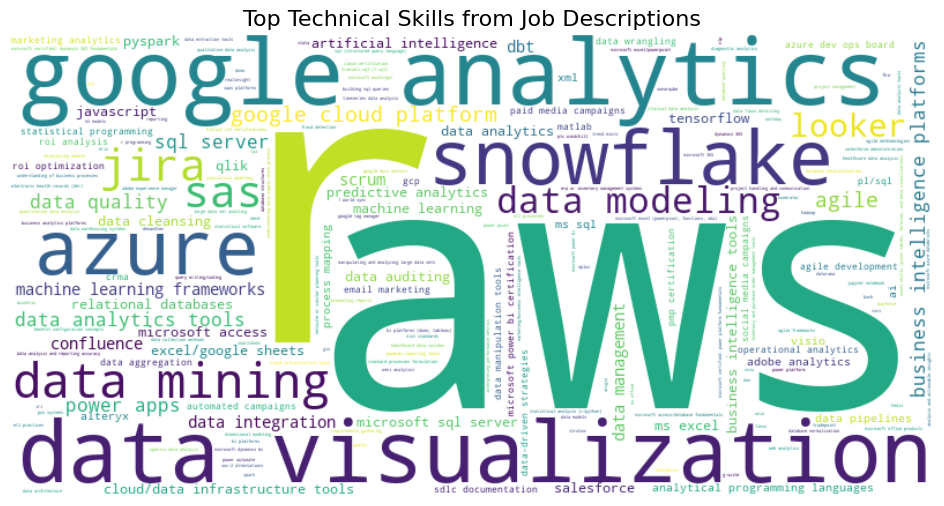

In [29]:
df_skills["Skill"] = df_skills["Skill"].str.lower().str.strip()
df_skills_filtered = df_skills[~df_skills["Skill"].isin(custom_stopwords)]


word_freq = dict(zip(df_skills_filtered["Skill"], df_skills_filtered["Frequency"]))


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_freq)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top Technical Skills from Job Descriptions", fontsize=16)
plt.show()

# ✅ Conclusion: Skill Gap Analysis Based on Job Descriptions

After filtering out technical skills I already possess (e.g., Python, SQL, Excel, Tableau, Power BI), I generated the word cloud shown above based on 200 job descriptions. This visualization reveals the most frequently mentioned technical skills that I have not yet fully mastered, providing clear guidance for future upskilling.

Key Takeaways:

	• AWS stands out as the most prominently required skill across the job postings, indicating a strong industry demand for cloud infrastructure expertise.
	• Other frequently occurring skill areas include:
	• Google Cloud Platform (GCP) and Azure, suggesting that multi-cloud proficiency is highly valuable.
	• Snowflake, Looker, and dbt, highlighting the increasing use of modern data stack tools.
	• Jira, Agile, and Scrum also appear often, reflecting a need to be familiar with project and workflow management tools.
	• Data modeling, data integration, and machine learning frameworks (e.g., TensorFlow) are also recurring themes, underlining the importance of mastering end-to-end data workflows.

Next Steps:

	• Prioritize learning AWS fundamentals and pursuing certification (e.g., AWS Cloud Practitioner or Solutions Architect Associate).
	• Get hands-on with Snowflake, dbt, and Looker through sandbox projects or tutorials.
	• Explore GCP or Azure depending on target companies.
	• Consider enhancing project management literacy with tools like Jira and principles like Agile/Scrum.